In [10]:
#https://github.com/vic22981106/RNN_BinaryAdditionTask/blob/master/RNN_BinaryAdditionTask.ipynb

# import the packages that I need
import numpy as np
import matplotlib.pyplot as plt

# sigmoid function and its derivative
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

def sigmoid_derivative(output):
    return output*(1-output)

# let the randomization different every time
a = np.random.randint(1,100)
np.random.seed(a)

# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]

epoch = 20000
lr = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1

# initialize neural network weights
W_inputtohidden = 2*np.random.random((input_dim,hidden_dim)) - 1
W_hiddenToOutput = 2*np.random.random((hidden_dim,output_dim)) - 1
W_hiddenTohidden = 2*np.random.random((hidden_dim,hidden_dim)) - 1

# generate 3 lists to store the upcoming gradients
W_inputtohidden_update = np.zeros_like(W_inputtohidden)
W_hiddenToOutput_update = np.zeros_like(W_hiddenToOutput)
W_hiddenTohidden_update = np.zeros_like(W_hiddenTohidden)

allError=[]
Acc = []
# training logic
for j in range(epoch):
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number/2) # int version
    a = int2binary[a_int] # binary version of a
    b_int = np.random.randint(largest_number/2) # int version
    b = int2binary[b_int] # binary verions of b

    # true answer
    c_int = a_int + b_int # int version of c
    c = int2binary[c_int] # binary version of c

    # i generate an array d for the best answer given by the machine (binary version)
    d = np.zeros_like(c)
    overallError = 0

    outputlayer_deltas = list()
    hidden_values = list()
    hidden_values.append(np.zeros(hidden_dim))

    # moving along the positions in the binary encoding
    for position in range(binary_dim):
        # generate input and output , move from right to left
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T

        # forward propagation
        hidden=sigmoid(np.dot(X,W_inputtohidden) + np.dot(hidden_values[-1],W_hiddenTohidden))
        # output layer (new binary representation)
        outputlayer = sigmoid(np.dot(hidden,W_hiddenToOutput))

        # calculate the loss value
        outputlayer_error = y - outputlayer
        outputlayer_deltas.append((outputlayer_error)*sigmoid_derivative(outputlayer)*(-1))
        Error = ((outputlayer_error)**2)/2

        # decode estimate
        # print("The OutputLayer (binary version): ",outputlayer[0][0])
        d[binary_dim - position - 1] = np.round(outputlayer[0][0])

        # store hidden layer foro BPTT
        hidden_values.append(hidden)

    # generate an array to store the hidden and hidden_delta at t + 1 for BPTT
    future_hidden_delta = np.zeros(hidden_dim)
    future_hidden = np.zeros(hidden_dim)

    for position in range(binary_dim):
        X = np.array([[a[position],b[position]]])
        hidden = hidden_values[-position-1]
        prev_hidden = hidden_values[-position-2]

        # error at output layer
        outputlayer_delta = outputlayer_deltas[-position-1]

        # error at hidden layer * sigmoid_derivative(future_hidden)
        hidden_delta = (future_hidden_delta.dot(W_hiddenTohidden.T) *
                        sigmoid_derivative(future_hidden) +
                        outputlayer_delta.dot(W_hiddenToOutput.T)) * \
                       sigmoid_derivative(hidden)

        # update all weights
        W_hiddenToOutput_update += np.atleast_2d(hidden).T.dot(outputlayer_delta)
        W_hiddenTohidden_update += np.atleast_2d(prev_hidden).T.dot(hidden_delta)
        W_inputtohidden_update += X.T.dot(hidden_delta)
        future_hidden_delta = hidden_delta
        future_hidden = hidden

    W_inputtohidden -= W_inputtohidden_update * lr
    W_hiddenToOutput -= W_hiddenToOutput_update * lr
    W_hiddenTohidden -= W_hiddenTohidden_update * lr

    W_inputtohidden_update *= 0
    W_hiddenToOutput_update *= 0
    W_hiddenTohidden_update *= 0


    correct = 0
    wrong = 0
    for i in range(binary_dim):
        if d[i]==c[i]:
            correct += 1
        else:
            wrong += 1
    accuracy = correct / binary_dim *100
    overallError = wrong / binary_dim * 100
    if j%100 == 0:
        Acc.append(accuracy)
        allError.append(overallError)

    # print out result
    if(j %1000 == 0):
        print("epoch",j)
        print("Pred:" , d)
        print("True:" ,c)
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print(a_int, " + ",b_int," = ",out)
        print("Error:",overallError)
        print("accuracy =", accuracy,"%")
        print("------------")

a: [0 1 0 0 0 0 1 1], b: [0 1 0 0 0 0 1 1], c: [1 0 0 0 0 1 1 0]
epoch 0
Pred: [0 0 0 0 0 0 0 0]
True: [1 0 0 0 0 1 1 0]
67  +  67  =  0
Error: 37.5
accuracy = 62.5 %
------------
a: [0 1 1 1 1 0 1 0], b: [0 0 0 0 1 0 1 0], c: [1 0 0 0 0 1 0 0]
a: [0 0 0 0 1 1 0 0], b: [0 0 1 1 1 1 1 0], c: [0 1 0 0 1 0 1 0]
a: [0 1 1 1 1 1 0 1], b: [0 0 1 1 1 0 0 1], c: [1 0 1 1 0 1 1 0]
a: [0 1 1 1 0 1 1 0], b: [0 1 1 0 0 1 1 1], c: [1 1 0 1 1 1 0 1]
a: [0 1 1 1 0 0 1 1], b: [0 1 0 1 1 0 1 0], c: [1 1 0 0 1 1 0 1]
a: [0 1 0 1 0 0 1 0], b: [0 1 0 1 1 0 0 1], c: [1 0 1 0 1 0 1 1]
a: [0 0 1 0 0 0 1 1], b: [0 0 0 1 0 1 1 1], c: [0 0 1 1 1 0 1 0]
a: [0 1 1 0 0 1 0 1], b: [0 0 0 0 1 0 0 0], c: [0 1 1 0 1 1 0 1]
a: [0 1 0 0 1 1 1 1], b: [0 0 1 1 0 0 1 0], c: [1 0 0 0 0 0 0 1]
a: [0 0 0 1 0 0 1 0], b: [0 0 0 1 0 1 0 0], c: [0 0 1 0 0 1 1 0]
a: [0 0 0 0 1 1 1 1], b: [0 0 1 1 0 1 0 0], c: [0 1 0 0 0 0 1 1]
a: [0 1 1 0 1 0 0 1], b: [0 1 1 0 1 0 1 0], c: [1 1 0 1 0 0 1 1]
a: [0 0 1 1 0 1 0 0], b: [0 0 0 1 0 0 1 

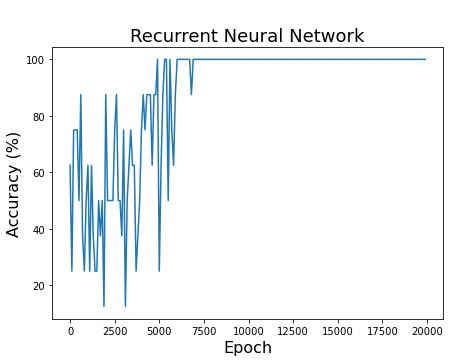

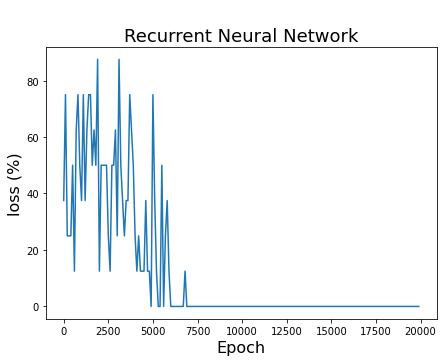

TypeError: unsupported format string passed to list.__format__

In [9]:
fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,20000,100)
plt.plot(epoch,Acc,linestyle="solid")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=16)
plt.title("\nRecurrent Neural Network",fontsize=18)
#plt.savefig('/Users/Anna/Desktop/RNN_Acc.png')
plt.show()

fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,20000,100)
plt.plot(epoch,allError,linestyle="solid")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("loss (%)",fontsize=16)
plt.title("\nRecurrent Neural Network",fontsize=18)
#plt.savefig('/Users/vincent/Desktop/RNN_Loss.png')
plt.show()

In [5]:
for i in range(10):

    a_int = np.random.randint(largest_number/2)
    a = int2binary[a_int]
    b_int = np.random.randint(largest_number/2)
    b = int2binary[b_int]

    # true answer
    c_int = a_int + b_int
    c = int2binary[c_int]
    d = np.zeros_like(c)

    hidden_values = list()
    hidden_values.append(np.zeros(hidden_dim))
    for position in range(binary_dim):
        # generate input and output , move from right to left
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T

        # forward propagation
        hidden=sigmoid(np.dot(X,W_inputtohidden) + np.dot(hidden_values[-1],W_hiddenTohidden))
        # output layer (new binary representation)
        outputlayer = sigmoid(np.dot(hidden,W_hiddenToOutput))
        d[binary_dim - position - 1] = np.round(outputlayer[0][0])
        # store hidden layer foro BPTT
        hidden_values.append(hidden)


    out = 0
    for index,x in enumerate(reversed(d)):
        out += x*pow(2,index)

    # msg = '{:<5}{:^3}{:<5}{:^3}{:<5}'.format( a_int,"+", b_int,"=", out)
    # print(msg)
    # print("%-.5s + %-.5s = %-.5s" % (a_int, b_int, out))
    print(a_int, " + ",b_int," = ",out)

7  +  114  =  121
101  +  108  =  209
45  +  65  =  110
90  +  104  =  194
13  +  112  =  125
64  +  83  =  147
67  +  16  =  83
24  +  18  =  42
110  +  47  =  157
5  +  105  =  110
